In [1]:
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# ฟังก์ชันตรวจจับ Moonshot
def detect_moonshot(data, window=12, threshold=0.05):
    moonshots = []
    for i in range(len(data) - window):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน 12 ชั่วโมงจากครั้งก่อน
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        # เงื่อนไข: ราคาขึ้น >= 5% และ low ไม่ลดเกิน 3%
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            moonshots.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'high_price': high_price,
                'moonshot_pct': moonshot_pct * 100,
                'window_end_time': data.index[i+window-1]
            })
    return pd.DataFrame(moonshots)

In [3]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close', 'volume']] if 'volume' in data.columns else data[['open', 'high', 'low', 'close']]

# คำนวณตัวชี้วัด RSI และ MACD
data['rsi'] = ta.rsi(data['close'], length=14)
macd = ta.macd(data['close'], fast=12, slow=26, signal=9)
data['macd'] = macd['MACD_12_26_9']
data['macd_signal'] = macd['MACDs_12_26_9']
data['macd_hist'] = macd['MACDh_12_26_9']

# ตรวจจับ Moonshot
moonshots = detect_moonshot(data, window=12, threshold=0.05)

In [4]:
moonshots

,start_time,close_price,high_price,moonshot_pct,window_end_time
0,2017-08-18 21:00:00+00:00,3975.69,4184.69,5.256949,2017-08-19 08:00:00+00:00
1,2017-08-22 04:00:00+00:00,3500.80,3990.12,13.977377,2017-08-22 15:00:00+00:00
2,2017-08-22 16:00:00+00:00,3905.84,4127.99,5.687637,2017-08-23 03:00:00+00:00
3,2017-08-23 05:00:00+00:00,4053.18,4265.80,5.245758,2017-08-23 16:00:00+00:00
4,2017-08-24 12:00:00+00:00,4150.89,4371.68,5.319100,2017-08-24 23:00:00+00:00
...,...,...,...,...,...
629,2025-03-11 00:00:00+00:00,77673.60,82092.34,5.688857,2025-03-11 11:00:00+00:00
630,2025-03-11 14:00:00+00:00,79773.04,83783.26,5.027037,2025-03-12 01:00:00+00:00
631,2025-04-07 06:00:00+00:00,74810.01,81243.58,8.599879,2025-04-07 17:00:00+00:00
632,2025-04-09 06:00:00+00:00,76829.02,82286.11,7.102902,2025-04-09 17:00:00+00:00


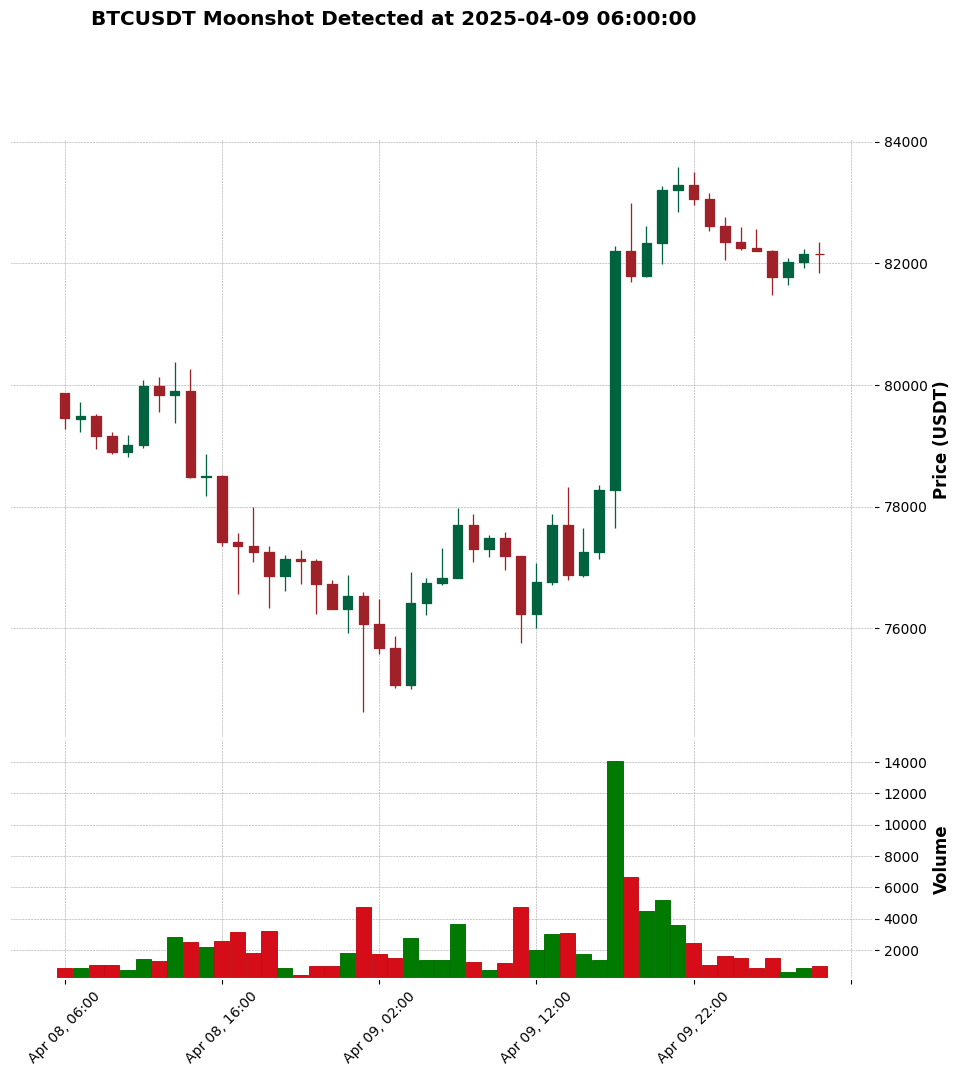

In [5]:
start_time = moonshots.iloc[-2]['start_time']
drip_data = data[start_time - timedelta(hours=24):start_time + timedelta(hours=24)]

mpf.plot(
  drip_data,
  type='candle',
  style='charles',
  title=f"BTCUSDT Moonshot Detected at {start_time.strftime('%Y-%m-%d %H:%M:%S')}",
  ylabel='Price (USDT)',
  volume=True,
  figsize=(12, 12)
)